# Домашняя работа 1


## Описание

В этой домашней работе вы должны применить знания по многослойным нейроным сетям 

- Для простоты попробуем обучить сначала однослойный перцептрон
- Решать будем простую задачу бинарной классификации
- Датасет игрушечный -  `load_data()` загружает его


In [1]:
import numpy as np
import torch
import tqdm
from torch import nn
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import copy
import torch.nn.init as init
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold

## Загрузка данных

In [2]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [3]:
gaussian_quantiles = load_data()
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


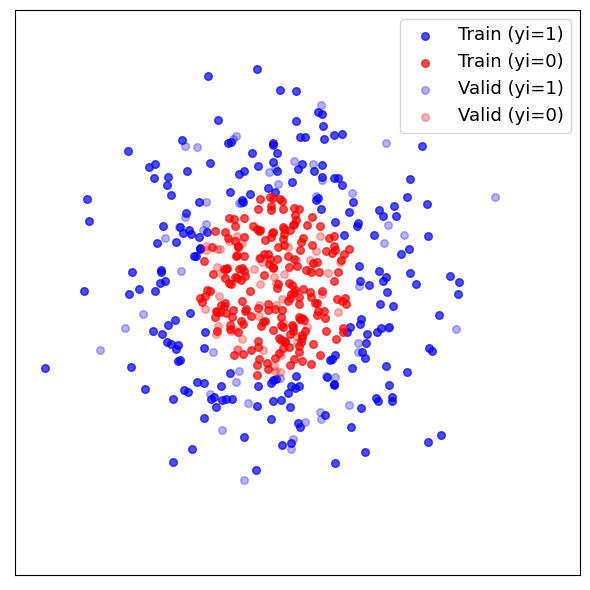

In [4]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

## Класс нейросети

Вам необходимо описать простую полносвязную многослойную нейронную сеть 

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 8)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(8, 8)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(8, 4)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Linear(4, 2)
        self.act4 = nn.ReLU()
        self.out = nn.Linear(2, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.act4(self.layer4(x))
        x = self.sig(self.out(x))
        return x  

##  Функция обучения сети

In [6]:
def model_train(model, loss_fn, opt, 
          n_epochs, batch_size, lr,
          X_train, y_train, X_val=None, y_val=None):
    
    x_train_loader = DataLoader(X_train, batch_size=batch_size)
    y_train_loader = DataLoader(y_train, batch_size=batch_size)
    x_val_ld = DataLoader(X_val, batch_size=1) if X_val is not None else None
    y_val_ld = DataLoader(y_val, batch_size=1) if y_val is not None else None

    batch_start = torch.arange(0, len(X_train), batch_size)
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
    preds_history = []
    loss_history = []
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for x_batch, y_batch in zip(x_train_loader, y_train_loader):
                # forward pass
                y_pred = model(x_batch)
                loss_val = loss_fn(y_pred, y_batch)
                loss_history.append(loss_val.item())
                # backward pass
                opt.zero_grad()
                loss_val.backward()
                # update weights
                opt.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss_val),
                    acc=float(acc)
                )
                
#         evaluate accuracy at end of each epoch
        if X_val is not None and y_val is not None:
            model.eval()
            y_pred = model(X_val)
            acc = (y_pred.round() == y_val).float().mean()
            acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        if acc > 0.98:
            break
            
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    
    return best_acc, loss_history

### Обучите сеть

Обучите сеть три раза - с тремя разными оптимизиторами
Не забудьте переинициализировать сеть заного перед каждой загрузкой. Убедитесь, что вы верно передали параметры сети в оптимизатор

**Подсказка** Лучше объявить три независимых объекта - модель1, модель2 и модель3

In [7]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float().reshape(-1, 1)
X_valid_torch = torch.from_numpy(X_test).float()
y_valid_torch = torch.from_numpy(y_test).float().reshape(-1, 1)

In [8]:
model1 = NeuralNetwork()
model2 = NeuralNetwork()
model3 = NeuralNetwork()

loss_SGD = []
loss_Adam = []
loss_rmsprop = []

optims = {
    'optim1': optim.SGD(model1.parameters(), lr = 0.03),
    'optim2': optim.Adam(model2.parameters(), lr = 0.01),
    'optim3': optim.RMSprop(model3.parameters(), lr = 0.001)
}

results = {}

for opt_name, opt in optims.items():
    if opt_name == 'optim1':
        model = model1
    elif opt_name == 'optim2':
        model = model2
    else:
        model = model3
    
    results[opt_name], lh = model_train(model, 
                                    nn.BCELoss(), 
                                    opt, 
                                    120, 
                                    30, 
                                    0.01, 
                                    X_train_torch, 
                                    y_train_torch, 
                                    X_valid_torch, 
                                    y_valid_torch)
    if opt_name == 'optim1':
        loss_SGD = lh
    elif opt_name == 'optim2':
        loss_Adam = lh
    else:
        loss_rmsprop = lh

Epoch 67:   0%|                                                         | 0/14 [00:00<?, ?batch/s, acc=0.7, loss=0.688]


Epoch 6:   0%|                                                          | 0/14 [00:00<?, ?batch/s, acc=0.9, loss=0.643]


Epoch 74:   0%|                                                            | 0/14 [00:00<?, ?batch/s, acc=1, loss=0.21]


Epoch 119:   0%|                                                          | 0/14 [00:00<?, ?batch/s, acc=1, loss=0.134]


In [9]:
results

{'optim1': 0.7400000095367432,
 'optim2': 0.9900000095367432,
 'optim3': 0.9700000286102295}

### А теперь посмотрим на графики лоссов

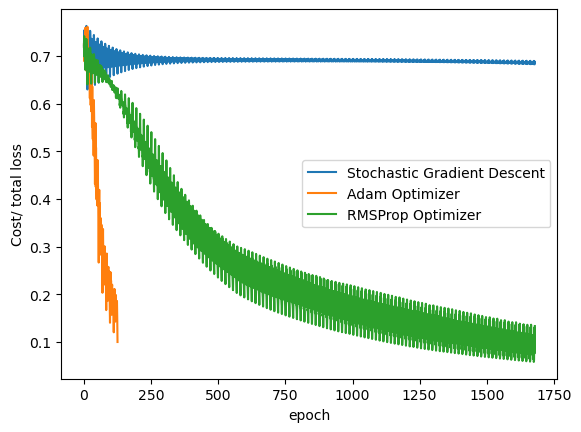

In [10]:
plt.plot(loss_SGD, label = "Stochastic Gradient Descent")
plt.plot(loss_Adam, label = "Adam Optimizer")
plt.plot(loss_rmsprop, label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

### Инициализация

Теперь проинициализируйте веса в вашей модели: случайно и Ксавьером. Сравните результат

In [11]:
# xavier
class NeuralNetworkXa(nn.Module):
    def __init__(self):
        super().__init__()        
        self.fc1 = nn.Linear(2, 8)
        self.fc2 = nn.Linear(8, 8)
        self.fc3 = nn.Linear(8, 4)
        self.fc4 = nn.Linear(4, 1)
        
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)
        
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.zeros_(self.fc4.bias)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x)) 
        return x

In [12]:
model1x = NeuralNetworkXa()
model2x = NeuralNetworkXa()
model3x = NeuralNetworkXa()


optims_x = {
    'optim1': optim.SGD(model1x.parameters(), lr = 0.03),
    'optim2': optim.Adam(model2x.parameters(), lr = 0.01),
    'optim3': optim.RMSprop(model3x.parameters(), lr = 0.001)
}

result_random = {}

for opt_name, opt in optims_x.items():
    if opt_name == 'optim1':
        model = model1x
    elif opt_name == 'optim2':
        model = model2x
    else:
        model = model3x
    
    result_random[opt_name], lh = model_train(model, 
                                    nn.BCELoss(), 
                                    opt, 
                                    120, 
                                    30, 
                                    0.01, 
                                    X_train_torch, 
                                    y_train_torch, 
                                    X_valid_torch, 
                                    y_valid_torch)
    if opt_name == 'optim1':
        loss_SGD = lh
    elif opt_name == 'optim2':
        loss_Adam = lh
    else:
        loss_rmsprop = lh

Epoch 67:   0%|                                                         | 0/14 [00:00<?, ?batch/s, acc=0.9, loss=0.102]


Epoch 9:   0%|                                                          | 0/14 [00:00<?, ?batch/s, acc=0.9, loss=0.534]


Epoch 33:   0%|                                                          | 0/14 [00:00<?, ?batch/s, acc=0.9, loss=0.23]


In [13]:
result_random

{'optim1': 0.9700000286102295,
 'optim2': 0.9900000095367432,
 'optim3': 0.9900000095367432}

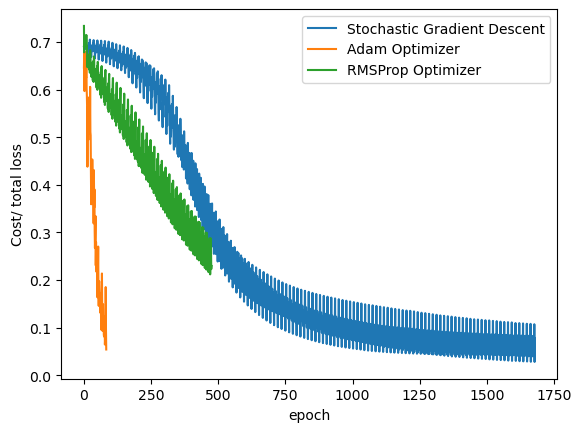

In [14]:
plt.plot(loss_SGD, label = "Stochastic Gradient Descent")
plt.plot(loss_Adam, label = "Adam Optimizer")
plt.plot(loss_rmsprop, label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

In [15]:
# random
class NeuralNetworkRand(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(2, 8)
        self.fc2 = nn.Linear(8, 8)
        self.fc3 = nn.Linear(8, 4)
        self.fc4 = nn.Linear(4, 1)
  
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)
        
        nn.init.normal_(self.fc3.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc3.bias, mean=0, std=0.01)
        
        nn.init.normal_(self.fc4.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc4.bias, mean=0, std=0.01)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x)) 
        return x

In [16]:
model1r = NeuralNetworkRand()
model2r = NeuralNetworkRand()
model3r = NeuralNetworkRand()


optims_rand = {
    'optim1': optim.SGD(model1r.parameters(), lr = 0.03),
    'optim2': optim.Adam(model2r.parameters(), lr = 0.01),
    'optim3': optim.RMSprop(model3r.parameters(), lr = 0.001)
}

result_random = {}

for opt_name, opt in optims_rand.items():
    if opt_name == 'optim1':
        model = model1r
    elif opt_name == 'optim2':
        model = model2r
    else:
        model = model3r
    
    result_random[opt_name], lh = model_train(model, 
                                    nn.BCELoss(), 
                                    opt, 
                                    120, 
                                    30, 
                                    0.01, 
                                    X_train_torch, 
                                    y_train_torch, 
                                    X_valid_torch, 
                                    y_valid_torch)
    if opt_name == 'optim1':
        loss_SGD = lh
    elif opt_name == 'optim2':
        loss_Adam = lh
    else:
        loss_rmsprop = lh

Epoch 67:   0%|                                                         | 0/14 [00:00<?, ?batch/s, acc=0.7, loss=0.688]


Epoch 15:   0%|                                                         | 0/14 [00:00<?, ?batch/s, acc=0.7, loss=0.688]


Epoch 83:   0%|                                                         | 0/14 [00:00<?, ?batch/s, acc=0.7, loss=0.688]


Epoch 31:   0%|                                                         | 0/14 [00:00<?, ?batch/s, acc=0.8, loss=0.501]


Epoch 99:   0%|                                                         | 0/14 [00:00<?, ?batch/s, acc=0.9, loss=0.273]


Epoch 119:   0%|                                                        | 0/14 [00:00<?, ?batch/s, acc=0.9, loss=0.161]


In [17]:
result_random

{'optim1': 0.5099999904632568,
 'optim2': 0.5099999904632568,
 'optim3': 0.9399999976158142}

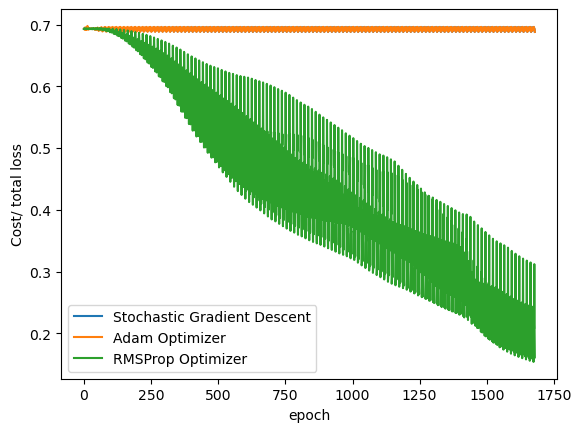

In [18]:
plt.plot(loss_SGD, label = "Stochastic Gradient Descent")
plt.plot(loss_Adam, label = "Adam Optimizer")
plt.plot(loss_rmsprop, label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

## А теперь решите многоклассовую проблему

Продемонстрируйте свои знания - решите более сложную проблему
Попробуйте разные инициализации, методы оптимизации и кол-во нейронов.

Найдите лучшие параметры через KFold

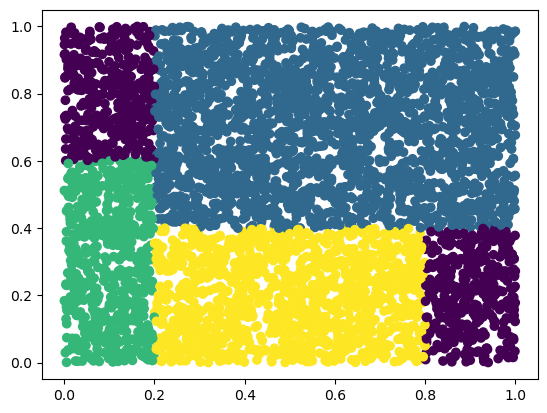

In [37]:
points = torch.rand(5000,2)
target = []
for p in points:
    if p[0]>0.2 and p[1]>0.4:
        target.append(1)
    elif p[0]<0.2 and p[1]<0.6:
        target.append(2)
    elif p[0]>0.2 and p[0]<0.8 and p[1] < 0.5:
        target.append(3)
    else:
        target.append(0)
        
target = torch.tensor(target) 
data = torch.cat((points, target.unsqueeze(1)), dim=1)

train = data[:800]
valid = data[800:900]
test = data[900:]

plt.scatter(data[:,0],data[:,1],c = data[:,2])
plt.show()

In [38]:
class AdvancedModel(nn.Module):
    def __init__(self):
        super(AdvancedModel, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(10, 8)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(8, 10)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(10, 4)  # меняем на 4, так как у нас 4 класса
        
    def forward(self, X):
        x = self.relu1(self.fc1(X))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        predictions = F.softmax(self.fc4(x), dim=1)  # софтмакс для получения вероятностей
        return predictions

In [39]:
def model_train(model, n_epochs, batch_size, optimizer, criterion,
                X_train, y_train, X_val, y_val):
    
    batch_start = torch.arange(0, len(X_train), batch_size)

    model.train()
    for epoch in range(n_epochs):
        for start in batch_start:
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            optimizer.zero_grad()
            out = model(X_batch)
            loss = criterion(out, y_batch.long())  # long, так как используем CrossEntropyLoss
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():  # не надо вычислять градиент, тк для текущей задачи не надо это
        out = model(X_val) 
        np, predicted = torch.max(out, 1) # получение индекса класса с наибольшей вероятностью: np - значения максимумов, predicted - индексы классов с наибольшими значениями, 1 - ось
        acc = (predicted == y_val.long()).float().mean().item()
    return acc

In [41]:
# поделим на 5 частей
kfold = StratifiedKFold(n_splits = 10, shuffle = True)
model_k = AdvancedModel()
opt = optim.Adam(model_k.parameters(), lr = 0.01)

accuracies = []
for train_indices, test_indices in kfold.split(points, target):   
    acc = model_train(model_k, 
                      50, 
                      10, 
                      opt, 
                      nn.CrossEntropyLoss(),
                      points[train_indices], target[train_indices],
                      points[test_indices], target[test_indices])
    
    print("Accuracy: %.2f" % acc)
    accuracies.append(acc)

# проведем оценку модели
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
print("Overall accuracy for AdvancedModel: %.2f%% (+/- %.2f%%))" % (mean_accuracy*100, std_accuracy*100))

Accuracy: 0.86
Accuracy: 0.88
Accuracy: 0.87
Accuracy: 0.84
Accuracy: 0.89
Accuracy: 0.89
Accuracy: 0.88
Accuracy: 0.90
Accuracy: 0.87
Accuracy: 0.88
Overall accuracy for AdvancedModel: 87.40% (+/- 1.64%))


## (Почти) Боевая задача
 
Перед вами датасет с классификацией алкоголя. Продемонстрируйте свои знания и решите задачу многоклассовой классификации

In [42]:
df = sklearn.datasets.load_wine(as_frame=True)
df = df.frame
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [43]:
# преобразую целевую переменную 
target = pd.get_dummies(df['target'])
target

,0,1,2
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
173,0,0,1
174,0,0,1
175,0,0,1
176,0,0,1


In [44]:
df.drop(columns=['target'], inplace=True)

# нормализуем признаки
df_normalized = (df - df.mean())/df.std()
df_normalized

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.514341,-0.560668,0.231400,-1.166303,1.908522,0.806722,1.031908,-0.657708,1.221438,0.251009,0.361158,1.842721,1.010159
1,0.245597,-0.498009,-0.825667,-2.483841,0.018094,0.567048,0.731565,-0.818411,-0.543189,-0.292496,0.404908,1.110317,0.962526
2,0.196325,0.021172,1.106214,-0.267982,0.088110,0.806722,1.212114,-0.497005,2.129959,0.268263,0.317409,0.786369,1.391224
3,1.686791,-0.345835,0.486554,-0.806975,0.928300,2.484437,1.462399,-0.979113,1.029251,1.182732,-0.426341,1.180741,2.328007
4,0.294868,0.227053,1.835226,0.450674,1.278379,0.806722,0.661485,0.226158,0.400275,-0.318377,0.361158,0.448336,-0.037767
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.873810,2.966176,0.304301,0.300954,-0.331985,-0.982841,-1.420891,1.270726,-0.927563,1.139596,-1.388840,-1.227742,-0.021890
174,0.491955,1.408636,0.413653,1.049555,0.158126,-0.791103,-1.280731,0.547563,-0.316058,0.967055,-1.126341,-1.481267,0.009866
175,0.331822,1.739837,-0.388260,0.151234,1.418411,-1.126646,-1.340800,0.547563,-0.420888,2.217979,-1.607590,-1.481267,0.279786
176,0.208643,0.227053,0.012696,0.151234,1.418411,-1.030776,-1.350811,1.351077,-0.228701,1.829761,-1.563840,-1.396759,0.295664


In [45]:
num_features = df.shape[1]
print("Количество признаков:", num_features)

Количество признаков: 13


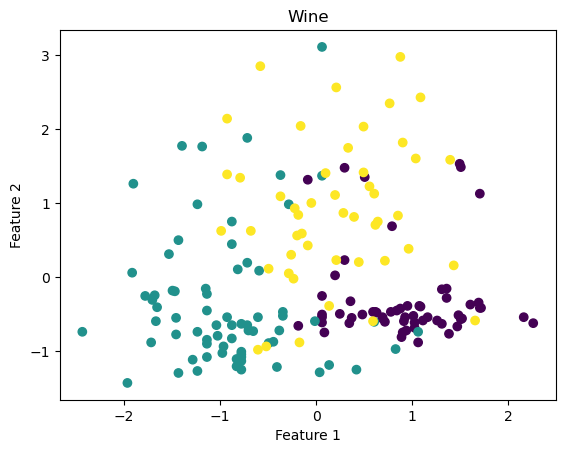

In [46]:
import matplotlib.pyplot as plt

wine = sklearn.datasets.load_wine()
 
X = wine.data 
y = wine.target  

X = (X - X.mean(axis=0))/X.std(axis=0)

data = np.column_stack((X, y))
data = torch.tensor(data, dtype=torch.float32)

train = data[:130]
valid = data[130:150]
test = data[150:]

plt.scatter(X[:, 0], X[:, 1], c = y, cmap = 'viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Wine')
plt.show()


In [47]:
# делим данные на трейн, валидацию и тест
X_train_valid, X_test, y_train_valid, y_test = train_test_split(df_normalized.values, target.values, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_valid, y_train_valid, test_size = 0.2, random_state = 42)

# надо преобразовать данные в тензоры
X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.float32)

X_val_tensor = torch.tensor(X_val, dtype = torch.float32)
y_val_tensor = torch.tensor(y_val, dtype = torch.float32)

X_test_tensor = torch.tensor(X_test, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.float32)

In [51]:
# создаем модель нейронной сети
class WineClassifier(nn.Module):
    def __init__(self):
        super(WineClassifier, self).__init__()
        self.fc1 = nn.Linear(13, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 3)  # так как 3 класса в df

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [52]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, optimizer, loss_fn, batch_size, epochs):
    val_losses = []
    val_accuracy = []
    
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            out = model(X_batch)
            loss = loss_fn(out, torch.argmax(y_batch, dim=1))
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_out = model(X_val)
            val_loss = loss_fn(val_out, torch.argmax(y_val, dim=1))
            val_losses.append(val_loss.item())
            val_acc = (torch.argmax(val_out, dim = 1) == torch.argmax(y_val, dim = 1)).float().mean().item()
            val_accuracy.append(val_acc)

    # Оценка модели на тесте
    model.eval()
    with torch.no_grad():
        test_out = model(X_test)
        test_loss = loss_fn(test_out, torch.argmax(y_test, dim = 1))
        test_accuracy = (torch.argmax(test_out, dim = 1) == torch.argmax(y_test, dim = 1)).float().mean().item()

    print(f'Test Loss: {test_loss.item():.3f}, Test Accuracy: {test_accuracy:.3f}')

    return val_losses, val_accuracy, test_loss.item(), test_accuracy

In [53]:
model_w = WineClassifier()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_w.parameters(), lr=0.001)

val_losses, val_accuracy, test_loss, test_accuracy = train_and_evaluate(model_w, 
                                                                        X_train_tensor, y_train_tensor, 
                                                                        X_val_tensor, y_val_tensor, 
                                                                        X_test_tensor, y_test_tensor, 
                                                                        optimizer, 
                                                                        loss_fn, 
                                                                        32, 
                                                                        100)

Test Loss: 0.003, Test Accuracy: 1.000
